# Deep Learning Final

### Cyber Network Intrusion Detection Deep Learning Model

In this notebook, I will be working with the CIC-IDS2018 dataset to build out a deep-learning approach to detect malious network ativity coming into the system. I will load in the data, analyze the distrubitons of malicous and benign activity, and determine the most improtant feature to catch malicous network activity. With theese features, I will train an autonecoder on the benign data. The idea behind this approach is to train an autonecoder to learn how to generate data similar to the benign data. Therefore, when malious activity is passed through the model, the model will produce a large reconstruction error. These reconstruction errors can then be used to determine if the activity is malicous or benign. Note: Due to resource constraints, only one data set was use for training anf testing.

## Step 1: Load in the Data and Analyze the basic components

In [44]:
df2 = pd.read_csv("archive/02-14-2018.csv")
df2.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


The first thing I want to do after loading the dataset is determine the types of attack present and how many examples of each are in the dataset.

In [46]:
print(df2["Label"].unique())
print(df2["Label"].value_counts())

['Benign' 'FTP-BruteForce' 'SSH-Bruteforce']
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64


I can use my knowledge of how these attacks work later on when I decide which features to include in training. However, for simplicity during my training, I will label the benign examples as 0 and the malicous examples as 1.

In [47]:
# create binary labels
df2["Label"] = df2["Label"].apply(lambda x: 0 if x == "Benign" else 1)

print(df2["Label"].value_counts())


0    667626
1    380949
Name: Label, dtype: int64


Now we can clean the data and make sure we still have enough examples.

In [48]:
import numpy as np

# clean data
df2.replace([np.inf, -np.inf], np.nan, inplace=True)  
df2.dropna(inplace=True)  

df2.reset_index(drop=True, inplace=True)

print(f"Dataset shape: {df2.shape}")


Dataset shape: (1044751, 80)


In [49]:
df2["Label"].value_counts()

0    663808
1    380943
Name: Label, dtype: int64

## Step 2: Conduct EDA

In this section of my notebook, I will do some data analysis to help me determine which features I want to use in my model. They key here is the keep the model lightweight so it can process incoming activity quickly while also robust enough to detect multiple attacks. 

The first thing I am going to do is plot the distrubutions of values for each column and color code the benign and malicious. In this eda, I am hoping to visually see certain features that are clearly different for both benign and malicous examples. Thes features would simplify the model design.

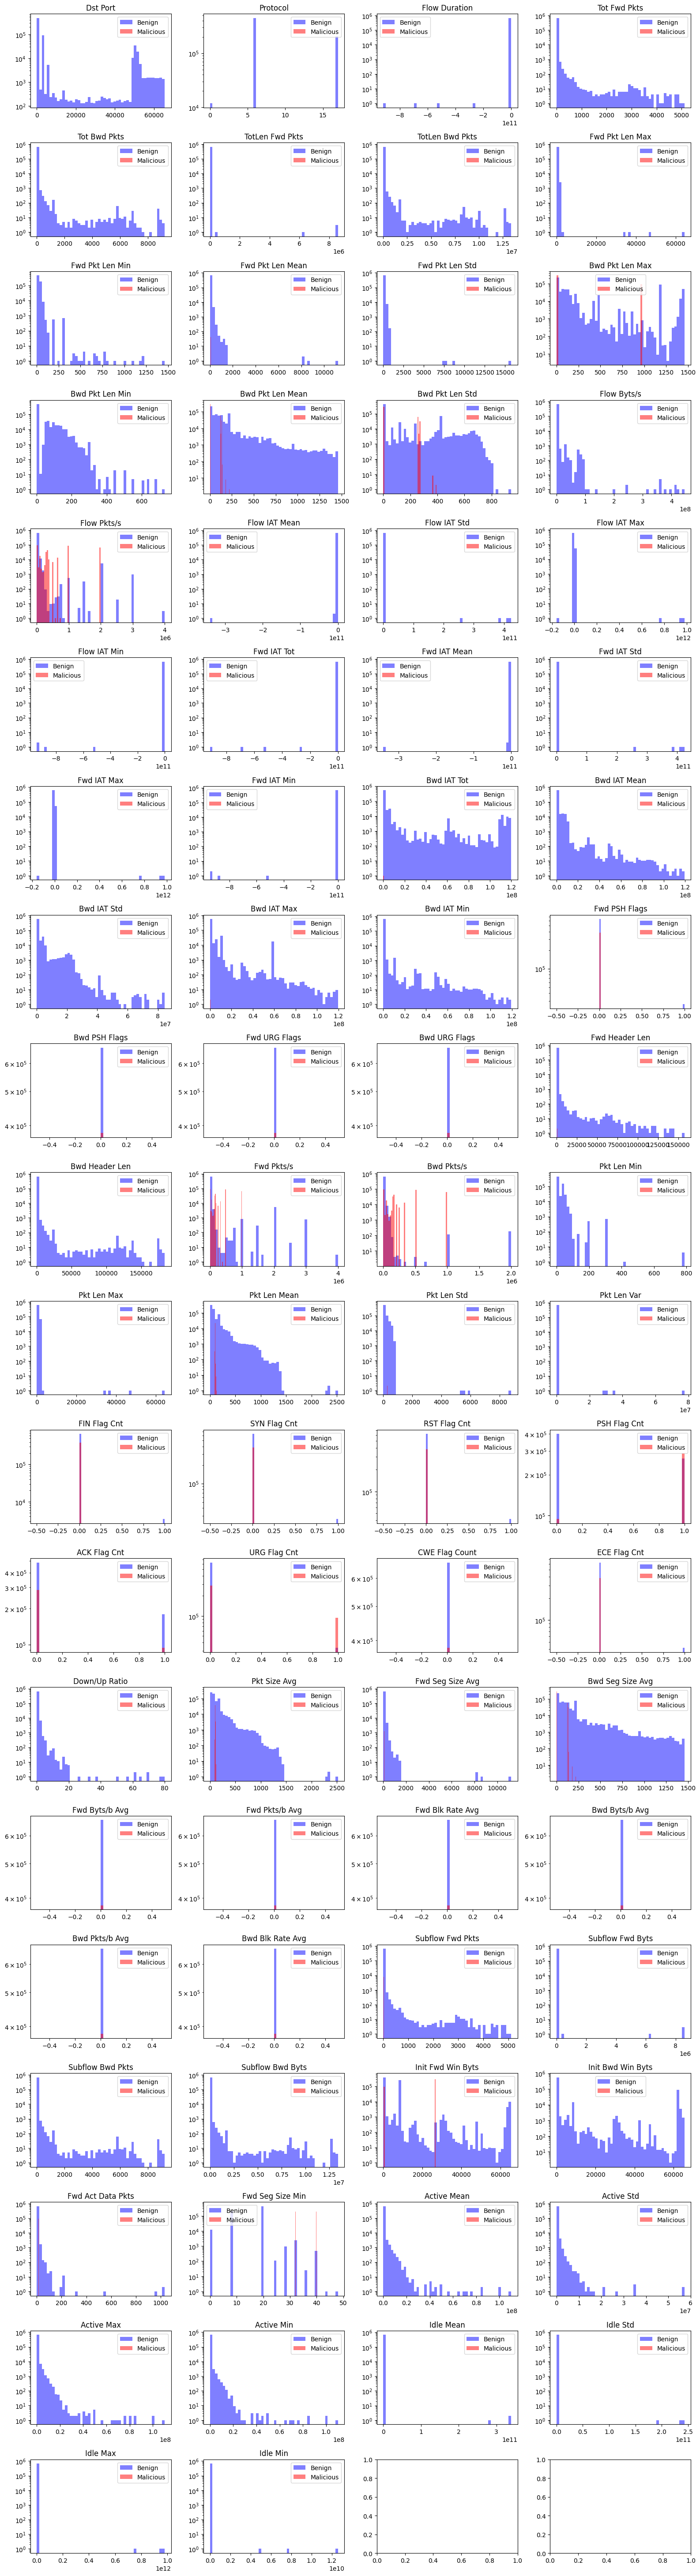

In [50]:
import matplotlib.pyplot as plt

df_numeric = df2.select_dtypes(include=['number'])

# set up plots
num_columns = len(df_numeric.columns) - 1  
fig, axes = plt.subplots(nrows=num_columns // 4 + 1, ncols=4, figsize=(16, num_columns * 0.75))
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    if col == "Label":
        continue  
    
    #benign and attack distributions
    axes[i].hist(df_numeric[df2["Label"] == 0][col], bins=50, alpha=0.5, color='blue', label='Benign')
    axes[i].hist(df_numeric[df2["Label"] == 1][col], bins=50, alpha=0.5, color='red', label='Malicious')

    axes[i].set_title(col)
    axes[i].set_yscale("log") 
    axes[i].legend()

plt.tight_layout()
plt.show()


In this dataset the Bwd Pkt Len Max, Min, and Mean for attacks to be a lot less variable than the benign examples. The difficulty becomes distinguising them from benign since they still exist in the benign distribution. However, based on this analysis, I am leaning toward incoprating them in the model training.

## Step 3: Invetigate more to determine most influential features

I have a strong gut feeling the BWD Pkt information will be used, but I want to verify the most influential features with another approach. I am going to do a correlation analysis to determine the top 15 features.

In [51]:
import pandas as pd

#correlation
correlation_scores = df2.corr()["Label"].abs().sort_values(ascending=False)

# top 15 features
top_15_features = correlation_scores[1:16].index.tolist()

print("Top 15 Selected Features (by Correlation):", top_15_features)


/var/folders/3p/mfldqhb13h758g1pnnh7r6vr0000gn/T/ipykernel_96103/930479496.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_scores = df2.corr()["Label"].abs().sort_values(ascending=False)


Top 15 Selected Features (by Correlation): ['Fwd Seg Size Min', 'Bwd Pkts/s', 'Init Fwd Win Byts', 'Flow Pkts/s', 'Fwd Pkts/s', 'Protocol', 'PSH Flag Cnt', 'Pkt Len Min', 'Pkt Size Avg', 'Bwd Pkt Len Min', 'Fwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'URG Flag Cnt']


After doing the correlation analysis, I looked back up at the charts produced above to verify the resuls as I thought eh Bwd Pkt information would have been higher. However, I can now see a few things I missed. Fwd Seg Size Min has two very thin lines that would make it easy to determine an attack. Additionally, Bwd Pkts/s has a wider distrubution for attacks than benign behavior signifying that it can be useful to determine what's anomolous. 

## Step 4: Preprocess Data

Using those top 15 features, I am going to train a base model. 

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

# Selected features
selected_features = [
    'Fwd Seg Size Min', 'Bwd Pkts/s', 'Init Fwd Win Byts', 'Flow Pkts/s', 'Fwd Pkts/s', 
    'Protocol', 'PSH Flag Cnt', 'Pkt Len Min', 'Pkt Size Avg', 'Bwd Pkt Len Min', 
    'Fwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Seg Size Avg', 'Down/Up Ratio', 'URG Flag Cnt'
]

#get top 15 features
df_selected = df2[selected_features + ['Label']].dropna()

#get benign data for training
benign_data = df_selected[df_selected['Label'] == 0].drop(columns=['Label']).values

# scale data
scaler = StandardScaler()
benign_data = scaler.fit_transform(benign_data)

print(f"Benign data shape: {benign_data.shape}")  # Should be (num_samples, 15)


Benign data shape: (663808, 15)


## Step 5: Create and train a base model

Now that we have our feature set, I am going to train a simple autoencoder to see how well it works. After training this model I will look for ways to improve it.

In [55]:

input_dim = benign_data.shape[1]

# autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(10, activation='relu')(input_layer)
encoded = Dense(5, activation='relu')(encoded)  

decoded = Dense(10, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 15)             │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 440 (1.72 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# train
history = autoencoder.fit(
    benign_data, benign_data,  
    epochs=20,
    batch_size=32,
    validation_split=0.2,  
    verbose=1
)


Epoch 1/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 229us/step - loss: 0.1924 - val_loss: 0.1209
Epoch 2/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 228us/step - loss: 0.1140 - val_loss: 0.1095
Epoch 3/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 226us/step - loss: 0.1090 - val_loss: 0.1062
Epoch 4/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 227us/step - loss: 0.1067 - val_loss: 0.1063
Epoch 5/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 228us/step - loss: 0.1064 - val_loss: 0.1062
Epoch 6/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 228us/step - loss: 0.1061 - val_loss: 0.1054
Epoch 7/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 230us/step - loss: 0.1055 - val_loss: 0.1064
Epoch 8/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 228us/step - loss: 0.1059 - val_loss: 0.1056
Epoch 9/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 230us/step - loss: 0.1058 - val_loss: 0.1060
Epoch 10/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 228us/step - loss: 0.1054 - val_loss: 0.1055
Epoch 11/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 4s 229us/step - loss: 0.1056 - val

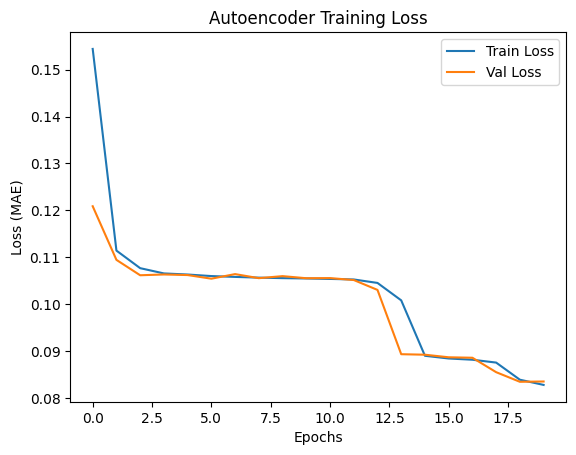

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()


The training process looks like it went well. The validation loss and train loss are following similar paths so I expect to see pretty solid results.

## Step 6: Test the model

Now we're going to use some data to test our model and verify our results. TO do this we will send in the test data and then find the optimal threshold to split our reconstruction losses. 

In [58]:
test_data = df_selected.copy().dropna()

X_test = test_data.drop(columns=['Label']).values 
y_test = test_data['Label'].values 

X_test = scaler.transform(X_test)

print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")


Test data shape: (1044751, 15), Labels shape: (1044751,)


In [59]:
# predict
X_test_reconstructed = autoencoder.predict(X_test)

reconstruction_error = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

reconstruction_error_df = pd.DataFrame({"Error": reconstruction_error, "Label": y_test})


32649/32649 ━━━━━━━━━━━━━━━━━━━━ 5s 160us/step


In [68]:
# get anomaly threshold
threshold = np.percentile(reconstruction_error_df[reconstruction_error_df["Label"] == 0]["Error"], 95)

# classify predictions
reconstruction_error_df["Predicted_Label"] = reconstruction_error_df["Error"].apply(lambda x: 1 if x > threshold else 0)

print(f"Anomaly threshold set at: {threshold:.4f}")


Anomaly threshold set at: 0.3998


With the threshold set, I will now check the results of the base model.

              precision    recall  f1-score   support

           0       0.87      0.95      0.91    663808
           1       0.90      0.75      0.82    380943

    accuracy                           0.88   1044751
   macro avg       0.88      0.85      0.86   1044751
weighted avg       0.88      0.88      0.88   1044751



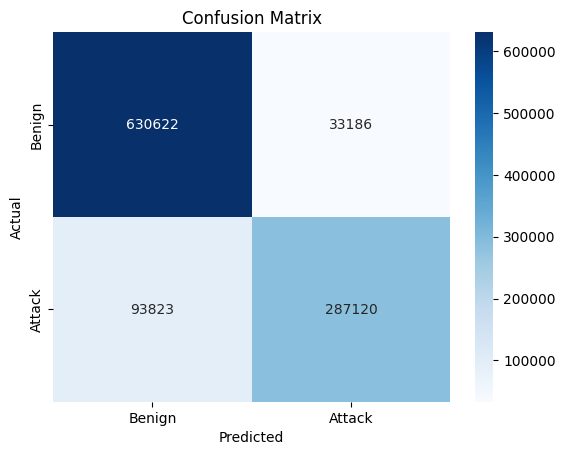

In [70]:
from sklearn.metrics import classification_report, confusion_matrix

#classification report
print(classification_report(reconstruction_error_df["Label"], reconstruction_error_df["Predicted_Label"]))

#sconfusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(reconstruction_error_df["Label"], reconstruction_error_df["Predicted_Label"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Step 7: Refine and Improve the Model

The base model shows pretty solid result, but it could definitley be better! I am going to improve the model but adding more depth, adding in batch norm layers, and also switch from MAE loss to MSE loss. 

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout

input_dim = benign_data.shape[1]

#encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)  

#decoder
decoded = Dense(16, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

autoencoder.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,119 (31.71 KB)

 Trainable params: 7,831 (30.59 KB)

 Non-trainable params: 288 (1.12 KB)

In [72]:
# train
history = autoencoder.fit(
    benign_data, benign_data,  
    epochs=20,
    batch_size=32,
    validation_split=0.2,  
    verbose=1
)


Epoch 1/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 8s 443us/step - loss: 0.1028 - val_loss: 0.0700
Epoch 2/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 7s 449us/step - loss: 0.0256 - val_loss: 0.0341
Epoch 3/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 7s 443us/step - loss: 0.0199 - val_loss: 0.0865
Epoch 4/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 7s 449us/step - loss: 0.0170 - val_loss: 0.0232
Epoch 5/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 7s 443us/step - loss: 0.0138 - val_loss: 0.0199
Epoch 6/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 7s 450us/step - loss: 0.0122 - val_loss: 0.0161
Epoch 7/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 8s 452us/step - loss: 0.0120 - val_loss: 0.0207
Epoch 8/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 7s 450us/step - loss: 0.0112 - val_loss: 0.0289
Epoch 9/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 7s 448us/step - loss: 0.0098 - val_loss: 0.0581
Epoch 10/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 8s 453us/step - loss: 0.0101 - val_loss: 0.0276
Epoch 11/20
16596/16596 ━━━━━━━━━━━━━━━━━━━━ 7s 449us/step - loss: 0.0088 - val

## Step 8: Test Improved Model

In [73]:
# predict
X_test_reconstructed = autoencoder.predict(X_test)

reconstruction_error = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

reconstruction_error_df = pd.DataFrame({"Error": reconstruction_error, "Label": y_test})


32649/32649 ━━━━━━━━━━━━━━━━━━━━ 6s 197us/step


In [74]:
# get anomaly threshold
threshold = np.percentile(reconstruction_error_df[reconstruction_error_df["Label"] == 0]["Error"], 95)

# classify predictions
reconstruction_error_df["Predicted_Label"] = reconstruction_error_df["Error"].apply(lambda x: 1 if x > threshold else 0)

print(f"Anomaly threshold set at: {threshold:.4f}")


Anomaly threshold set at: 0.0724


              precision    recall  f1-score   support

           0       1.00      0.95      0.97    663808
           1       0.92      1.00      0.96    380943

    accuracy                           0.97   1044751
   macro avg       0.96      0.97      0.97   1044751
weighted avg       0.97      0.97      0.97   1044751



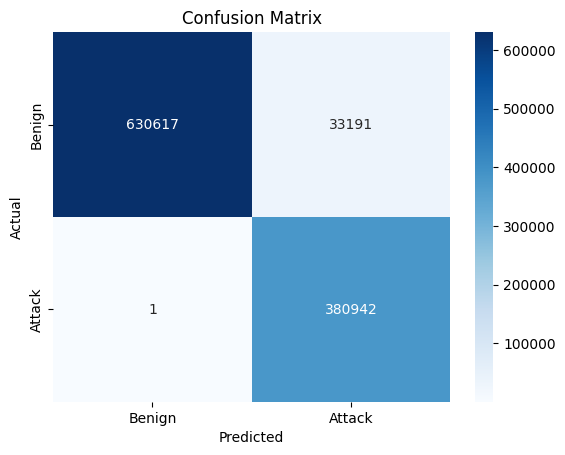

In [75]:
from sklearn.metrics import classification_report, confusion_matrix

#classification report
print(classification_report(reconstruction_error_df["Label"], reconstruction_error_df["Predicted_Label"]))

#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(reconstruction_error_df["Label"], reconstruction_error_df["Predicted_Label"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Conclusion

After adding more depth into the model along with batch norm layers and changing the loss function from MAE to MSE, I saw a signifigant improvement in the models performance. After conducting EDA, data clensing, and initial model training exeriments I verifed the autoencoder apporach works. Finally, I improved the deep learning aspect of my autencoder by adding in more layers which improved by model's f1 scores from 0.91 - beningn  & 0.82 - malicious up to 0.97 - benign and 0.96 - malicious.  